In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
from skimage.transform import radon
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DetrImageProcessor
from PIL import Image
import warnings
from time import time
from train import *


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
from skimage.transform import radon
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DetrImageProcessor
from PIL import Image
import warnings
from time import time
from train import *


print(f"Loading processor: {config.PROCESSOR_NAME}")
# Define 'processor' globally so collate_fn can access it
processor = DetrImageProcessor.from_pretrained(config.PROCESSOR_NAME)

print("Creating training dataset...")
train_dir = config.DATA_DIR / "train"
train_dataset = PreGeneratedRadonDataset(
    data_dir=train_dir,
    processor=processor,
    box_width=config.BOX_WIDTH_PX,  
    box_height=config.BOX_HEIGHT_PX,
    class_id=config.CLASS_ID
)

Loading processor: facebook/detr-resnet-50
Creating training dataset...
Dataset at radon_dataset/train found 260 samples.
Detected sample dimensions: (H=256, W=256)
Creating validation dataset...
Dataset at radon_dataset/val found 1 samples.
Detected sample dimensions: (H=256, W=256)
Creating dataloaders...

Data loading pipeline successfully created.
Loading processor: facebook/detr-resnet-50
Creating training dataset...
Dataset at radon_dataset/train found 260 samples.
Detected sample dimensions: (H=256, W=256)


In [69]:
train_dataloader = DataLoader(
    train_dataset, 
    collate_fn=collate_fn, 
    batch_size=497, 
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

In [70]:
batch = next(iter(train_dataloader))

In [72]:
batch.shape

AttributeError: 'dict' object has no attribute 'shape'

In [62]:
x=np.load('radon_dataset/train/')

In [65]:
x['r_image']

(256, 256, 1)

In [13]:
batch['pixel_values'].shape

torch.Size([8, 3, 800, 800])


Visualizing one sample from the dataloader with actual bounding boxes...


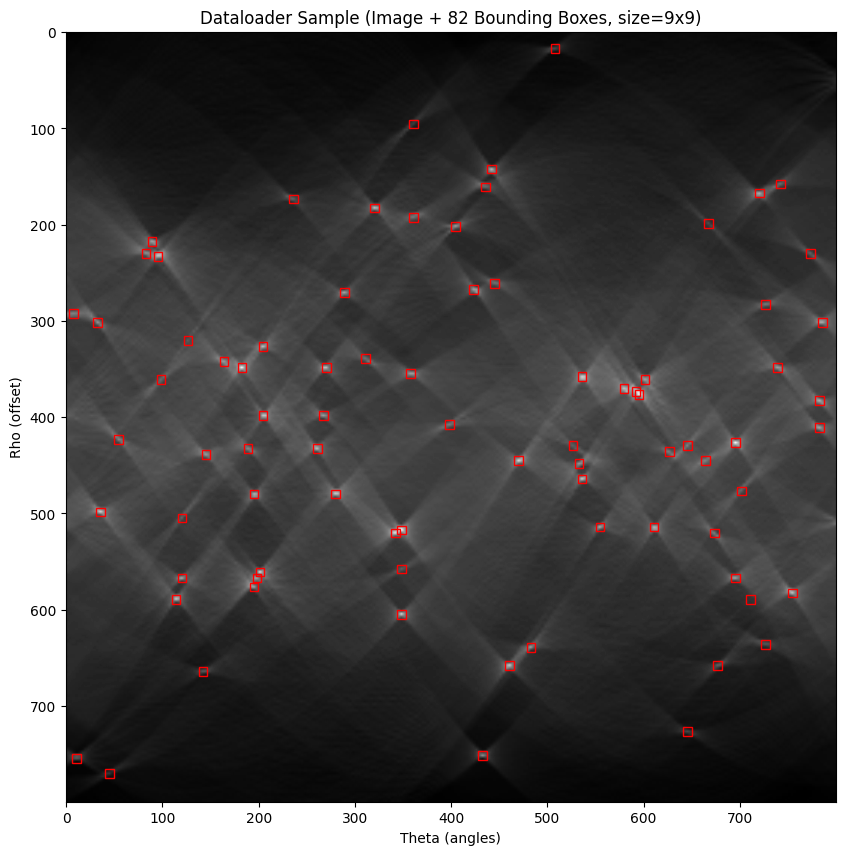

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch


PLOT_BOX_HEIGHT = 9

print("\nVisualizing one sample from the dataloader with actual bounding boxes...")

# Get a single batch
batch = next(iter(train_dataloader))

# Select the first item in the batch
idx = 0
pixel_values = batch['pixel_values'][idx] # (C, H_pad, W_pad)
pixel_mask = batch['pixel_mask'][idx]   # (H_pad, W_pad)
target = batch['labels'][idx]         # Dict with 'boxes', 'class_labels'

# --- 1. Un-normalize and Un-pad the Image ---

# Get original (un-padded) dimensions from the mask
h = pixel_mask.sum(dim=0).bool().sum().item()
w = pixel_mask.sum(dim=1).bool().sum().item()

# De-normalize image
mean = torch.tensor(processor.image_mean).view(3, 1, 1)
std = torch.tensor(processor.image_std).view(3, 1, 1)
unnormalized_image = (pixel_values * std + mean)

# Crop to original size
unpadded_image = unnormalized_image[:, :h, :w]

# Convert to numpy (H, W, C) for plotting
# Since it's grayscale, we just take the first channel
img_to_plot = unpadded_image[0].cpu().numpy()

# --- 2. De-normalize Target Boxes and Convert to (x_min, y_min, width, height) for plotting ---
# Boxes are [center_x, center_y, width, height] normalized
boxes_normalized = target['boxes'].cpu().numpy()

# Denormalize and convert to (x_min, y_min, width, height)
# For plotting, we'll use the PLOT_BOX_WIDTH/HEIGHT for the final bounding box size.
# The `boxes_normalized` has width/height as 1/IMG_SIZE and 1/THETA_RES.
# We want to center our PLOT_BOX_WIDTH/HEIGHT around the original peak location.

plot_boxes = []
for box in boxes_normalized:
    center_x_norm, center_y_norm, _, _ = box # We ignore normalized width/height for plotting
    
    # Denormalized center coordinates
    center_x = center_x_norm * w
    center_y = center_y_norm * h

    # Calculate top-left corner for plotting (x_min, y_min)
    # This centers the desired PLOT_BOX around the original peak
    x_min = center_x - (PLOT_BOX_WIDTH / 2)
    y_min = center_y - (PLOT_BOX_HEIGHT / 2)

    plot_boxes.append([x_min, y_min, PLOT_BOX_WIDTH, PLOT_BOX_HEIGHT])

# --- 3. Plot ---
plt.figure(figsize=(10, 10))
ax = plt.gca() # Get current axes for drawing rectangles

plt.imshow(img_to_plot, cmap='gray')

# Add bounding boxes to the plot
for box_coords in plot_boxes:
    x_min, y_min, box_w, box_h = box_coords
    rect = patches.Rectangle(
        (x_min, y_min), box_w, box_h, 
        linewidth=1, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)

plt.title(f"Dataloader Sample (Image + {len(plot_boxes)} Bounding Boxes, size={PLOT_BOX_WIDTH}x{PLOT_BOX_HEIGHT})")
plt.xlabel("Theta (angles)")
plt.ylabel("Rho (offset)")
plt.show()

In [21]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

/opt/miniconda3/envs/ml/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


ValueError: Make sure that you pass in as many target sizes as the batch dimension of the logits

In [35]:
from transformers import DetrImageProcessor, DetrForObjectDetection

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

outputs = model(**batch)
loss=outputs['loss']
loss.backward()


In [41]:
batch['pi']

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [47]:
batch['pixel_mask']

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        ...,

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1,